In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle

plt.rcParams["figure.figsize"] = (20,10)

%matplotlib inline

In [3]:
color_dict = {
    1610612737: ('#E13A3E', 'ATL'),
    1610612738: ('#008348', 'BOS'),
    1610612751: ('#061922', 'BKN'),
    1610612766: ('#1D1160', 'CHA'),
    1610612741: ('#CE1141', 'CHI'),
    1610612739: ('#860038', 'CLE'),
    1610612742: ('#007DC5', 'DAL'),
    1610612743: ('#4D90CD', 'DEN'),
    1610612765: ('#006BB6', 'DET'),
    1610612744: ('#FDB927', 'GSW'),
    1610612745: ('#CE1141', 'HOU'),
    1610612754: ('#00275D', 'IND'),
    1610612746: ('#ED174C', 'LAC'),
    1610612747: ('#552582', 'LAL'),
    1610612763: ('#0F586C', 'MEM'),
    1610612748: ('#98002E', 'MIA'),
    1610612749: ('#00471B', 'MIL'),
    1610612750: ('#005083', 'MIN'),
    1610612740: ('#002B5C', 'NOP'),
    1610612752: ('#006BB6', 'NYK'),
    1610612760: ('#007DC3', 'OKC'),
    1610612753: ('#007DC5', 'ORL'),
    1610612755: ('#006BB6', 'PHI'),
    1610612756: ('#1D1160', 'PHX'),
    1610612757: ('#E03A3E', 'POR'),
    1610612758: ('#724C9F', 'SAC'),
    1610612759: ('#BAC3C9', 'SAS'),
    1610612761: ('#000000', 'TOR'),
    1610612762: ('#00471B', 'UTA'),
    1610612764: ('#002B5C', 'WAS'),
}

In [4]:
gameid='0021500188'
# gameid = '0021500477'

# directories
# CHANGE HERE
data_dir = 'raptors/'
game_dir = data_dir+'data/'
court_path = data_dir + 'nba_court_T.png'


#open the pickle file
with open(game_dir+gameid+'.pkl', 'rb') as handle:
    datta = pickle.load(handle)

In [5]:
def draw_court(ii, jj):
    num_events = len(datta['events'])

    player_fields = datta['events'][0]['home']['players'][0].keys()
    # CHANGE THIS
    # specify an event number

    home_players = pd.DataFrame(data=[i for i in datta['events'][0]['home']['players']], columns=player_fields)
    away_players = pd.DataFrame(data=[i for i in datta['events'][0]['visitor']['players']], columns=player_fields)
    players = pd.merge(home_players, away_players, how='outer')
    jerseydict = dict(zip(players.playerid.values, players.jersey.values))

    # get the position of the players and the ball throughout the event
    ball_xy = np.array([x[5][0][2:5] for x in datta['events'][ii]['moments']]) #create matrix of ball data
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][ii]['moments']]) #create matrix of player data

    # get the play by play data for this clip
    playbyplay = datta['events'][ii]['playbyplay']
    team_1_xy_mean = -np.ones((len(player_xy),2))
    team_2_xy_mean = -np.ones((len(player_xy),2))


    # CHANGE THIS
    # plot a certain frame:
    #jj = (len(player_xy) - 1) / 2

    print('event ' + str(ii) + '/' + str(num_events) + ", moment: "+ str(jj) + '/'+ str(len(player_xy)))
    fig = plt.figure()
    ax = plt.gca() #create axis object


    img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

    plt.imshow(img, extent=[0,94,0,50], zorder=0)  # show the image.

    # get player and ball data for the momenet
    ball = ball_xy[jj]
    player = player_xy[jj]


    # plot clock info
    clock_info = ax.annotate('', xy=[94.0/2 - 6.0/1.5 +0.1, 50 - 6.0/1.5 -0.35],
        color='black', horizontalalignment='center', verticalalignment='center')

    if not datta['events'][ii]['moments'][jj][0] == None:
        quarter = datta['events'][ii]['moments'][jj][0]
    else:
        quarter = 0

    if not datta['events'][ii]['moments'][jj][2] == None:
        game_clock = datta['events'][ii]['moments'][jj][2]
    else:
        game_clock = 0

    if not datta['events'][ii]['moments'][jj][3] == None:
        game_shot = datta['events'][ii]['moments'][jj][3]
    else:
        game_shot = 0

    clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
        quarter,
        int(game_clock) % 3600 // 60,
        int(game_clock) % 60,
        game_shot)
    clock_info.set_text(clock_test)

    # the event title
    temp = str(datta['events'][ii]['home']['abbreviation'])+\
        ' vs. ' + str(datta['events'][ii]['visitor']['abbreviation'])+\
        '\n'
    for idx, pp in playbyplay.iterrows():
        temp = temp + str(pp['HOMEDESCRIPTION'])+ " , " +\
                str(pp['VISITORDESCRIPTION'])+ " , "+\
                str(pp['PCTIMESTRING'])+ " , "+\
                str(pp['event_str'])  + '\n'


    plt.title(temp)

    for kk in range(player.shape[0]): #create circle object and text object for each player

        #
        #kk = 1
        #
        team_id = player[kk,0]
        player_id = player[kk,1]
        xx = player[kk,2]
        yy  =player[kk, 3]

        # player circle
        player_circ = plt.Circle((xx,yy), 2.2,
                        facecolor=color_dict[team_id][0],edgecolor='k')
        ax.add_artist(player_circ)

        # player jersey # (text)
        ax.text(xx,yy,jerseydict[player_id],color='w',ha='center',va='center')

    # draw the ball
    ball_circ = plt.Circle((ball[0], ball[1]), ball[2]/3, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)

    # add the average position of each team tp the frame
    team_ids = np.unique(player[:,0])

    team_1_xy = player[player[:,0] == team_ids[0]]
    team_1_xy = team_1_xy[:,[2,3]]
    team_1_xy_mean[jj,:] = np.mean(team_1_xy,0)
    plt.plot(team_1_xy_mean[:jj+1,0],team_1_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[0]][0],
             alpha=0.2)


    team_2_xy = player[player[:,0] == team_ids[1]]
    team_2_xy = team_2_xy[:,[2,3]]
    team_2_xy_mean[jj,:] = np.mean(team_2_xy,0)
    plt.plot(team_2_xy_mean[:jj+1,0],team_2_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[1]][0],
             alpha=0.2)

    plt.xlim([0,94])
    plt.ylim([0,50])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)


In [41]:
num_events = len(datta['events'])
count = 0
for i in xrange(num_events):
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][i]['moments']])
    count += len(player_xy)
print count

111781


In [36]:
print 111781 / 25. / 60

74.5206666667


In [33]:
575/25

23

In [93]:
draw_court()

350
200
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
201
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.

In [91]:
event_num = 5
print len(datta['events'][event_num]['moments'])

for frame in xrange(0, 10):
    print datta['events'][event_num]['moments'][frame]


325
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.0], [161

In [6]:
def time_conversion(quarter, time_left_in_quarter):
    time_passed = quarter * 12 * 60 - time_left_in_quarter
    time_left_in_game = (48 * 60) - time_passed
    return time_left_in_game

In [7]:
# Find the scoring with assis moments
ast_list = []
attacker = []
ast_events = []
home_team = datta['events'][0]['home']['teamid']
away_team = datta['events'][0]['visitor']['teamid']
num_events = len(datta['events'])
# Look through the data locate where the scoring with assist happens
for i in xrange(num_events):
    playbyplay = datta['events'][i]['playbyplay']
    for idx, play in playbyplay.iterrows():
        if play['HOMEDESCRIPTION'] != None:
            if play['HOMEDESCRIPTION'].find(' AST)') != -1:
                print play['HOMEDESCRIPTION']
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                print time_left_in_quarter, time_left_in_game
                ast_list.append(time_left_in_game)
                attacker.append(home_team)
                ast_events.append(i)
        if play['VISITORDESCRIPTION'] != None:
            if play['VISITORDESCRIPTION'].find(' AST)') != -1:
                print play['VISITORDESCRIPTION']
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                print time_left_in_quarter, time_left_in_game
                ast_list.append(time_left_in_game)
                attacker.append(away_team)
                ast_events.append(i)

ast_events = list(set(ast_events))
ast_events.sort()
ast_times, index = np.unique(ast_list, return_index = True)
attacker = np.array([attacker[i] for i in index])

event_data = pd.DataFrame(data={'attack': attacker, 'time':ast_times})
print event_data

Lowry 24' 3PT Jump Shot (3 PTS) (DeRozan 1 AST)
632 2792
Lowry 24' 3PT Jump Shot (3 PTS) (DeRozan 1 AST)
632 2792
Russell 25' 3PT Jump Shot (3 PTS) (Bryant 1 AST)
498 2658
Russell 25' 3PT Jump Shot (3 PTS) (Bryant 1 AST)
498 2658
Clarkson 2' Alley Oop Layup (4 PTS) (Russell 1 AST)
474 2634
Clarkson 2' Alley Oop Layup (4 PTS) (Russell 1 AST)
474 2634
Russell 10' Jump Shot (5 PTS) (Bryant 2 AST)
440 2600
Russell 10' Jump Shot (5 PTS) (Bryant 2 AST)
440 2600
DeRozan  3PT Jump Shot (5 PTS) (Valanciunas 1 AST)
421 2581
Clarkson 2' Driving Finger Roll Layup (6 PTS) (Hibbert 1 AST)
406 2566
Bryant 11' Jump Shot (2 PTS) (Clarkson 1 AST)
382 2542
Bryant 11' Jump Shot (2 PTS) (Clarkson 1 AST)
382 2542
Lowry 25' 3PT Jump Shot (9 PTS) (Carroll 1 AST)
276 2436
Lowry 25' 3PT Jump Shot (9 PTS) (Carroll 1 AST)
276 2436
Ross 25' 3PT Jump Shot (3 PTS) (Lowry 1 AST)
172 2332
Ross 14' Pullup Jump Shot (5 PTS) (Valanciunas 2 AST)
109 2269
Ross 14' Pullup Jump Shot (5 PTS) (Valanciunas 2 AST)
109 2269
Hibbe

In [72]:
# Get the start time of each event
event_start_time = []
for i in xrange(num_events):
    moment = datta['events'][i]['moments']
    quarter = moment[0][0]
    time_left_in_quarter = moment[0][2]
    event_start_time.append(time_conversion(quarter, time_left_in_quarter))
# Get the list of frames of events where AST happens wihtout overlap
moment_data = []
moment_location = []
for i in reversed(xrange(num_events)):
    print i, num_events
    moment = datta['events'][i]['moments']
    for j in reversed(xrange(len(moment))):
        quarter = moment[j][0]
        time_left_in_quarter = moment[j][2]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)
        
        if time_left_in_game == event_start_time[i]:
            print "moving on"
            break

        # Get meta data
        a = moment[j][:4]
        a.append(i)
        a.append(j)
        
        moment_data.append(a)        
        # Get location data
        location = pd.DataFrame(moment[j][5])
        ball = location.iloc[0, :]
        home = location[location[0] == home_team]
        away = location[location[0] == away_team]
        moment_location.append([ball, home, away])
        


216 217
moving on
215 217
moving on
214 217
moving on
213 217
moving on
212 217
moving on
211 217
moving on
210 217
moving on
209 217
moving on
208 217
moving on
207 217
moving on
206 217
moving on
205 217
moving on
204 217
moving on
203 217
moving on
202 217
moving on
201 217
moving on
200 217
moving on
199 217
moving on
198 217
moving on
197 217
moving on
196 217
moving on
195 217
moving on
194 217
moving on
193 217
moving on
192 217
moving on
191 217
moving on
190 217
moving on
189 217
moving on
188 217
moving on
187 217
moving on
186 217
moving on
185 217
moving on
184 217
moving on
183 217
moving on
182 217
moving on
181 217
moving on
180 217
moving on
179 217
moving on
178 217
moving on
177 217
moving on
176 217
moving on
175 217
moving on
174 217
moving on
173 217
moving on
172 217
moving on
171 217
moving on
170 217
moving on
169 217
moving on
168 217
moving on
167 217
moving on
166 217
moving on
165 217
moving on
164 217
moving on
163 217
moving on
162 217
moving on
161 217
mo

In [74]:
# Go through and find frames exactly where shot happens and when assist happens
# Check when the clock resets
search_counter = 0
counter = 0
prev_time_left_in_game = 0
prev_shot_clock = 0
time_stopped = False
shot_stopped = False
slack_time = 5
for i in xrange(len(moment_data)):
    quarter = moment_data[i][0]
    time_left_in_quarter = moment_data[i][2]
    shot_clock = moment_data[i][3]
    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
    search_time = event_data.time[search_counter]

    
    if prev_time_left_in_game == time_left_in_game and time_stopped == False:
        time_stopped = True
        # print 'time stopped'
        # print prev_time_left_in_game, time_left_in_game
    
    if prev_time_left_in_game != time_left_in_game and time_stopped == True:
        time_stopped = False
        # print prev_time_left_in_game, time_left_in_game, search_time
        if prev_time_left_in_game > search_time - slack_time: #and prev_time_left_in_game < search_time + 1:
            print 'time started'
            print 'time', moment_data[i], time_left_in_game, event_data.time[search_counter]            
            search_counter = search_counter + 1
            time_stopped = False
        
    if prev_shot_clock > shot_clock and shot_clock != None and prev_shot_clock != None:
        # print prev_shot_clock, shot_clock, time_left_in_game
        # print "Shot Clock Reset", time_left_in_game, prev_shot_clock, shot_clock
        if time_left_in_game > search_time - slack_time:
            if prev_shot_clock > 23.9:
                print 'shot', moment_data[i], prev_time_left_in_game, event_data.time[search_counter]
            search_counter = search_counter + 1

    prev_shot_clock = shot_clock
    prev_time_left_in_game = time_left_in_game
    
    if search_counter >= len(event_data):
        break
#            break
#        if counter == 0:
#            for j in reversed(xrange(50)):
#               
#        print moment_data[i], time_left_in_game, event_data.time[search_counter]
#        counter = counter + 1
#        if counter >= 50:
#            counter = 0


shot [4, 1448084558963, 24.71, 2.13, 212, 474] 24.67 24
shot [4, 1448083758429, 378.03, 16.89, 188, 402] 377.99 377
shot [4, 1448083407281, 477.95, 17.3, 179, 57] 477.91 478
shot [4, 1448083079572, 653.9, 6.95, 169, 314] 653.86 651
shot [4, 1448083060412, 673.07, 14.1, 168, 360] 673.03 670
shot [4, 1448083048213, 685.27, 5.3, 168, 55] 685.23 682
shot [3, 1448082648026, 88.8, 23.01, 157, 625] 808.96 792
shot [3, 1448082625986, 110.64, 6.13, 157, 74] 830.6 828
shot [3, 1448082111523, 311.3, 11.96, 142, 13] 1031.26 1029
shot [3, 1448081566501, 525.52, 2.47, 138, 5737] 1245.48 1242
shot [3, 1448081436866, 596.8, 1.88, 138, 3584] 1316.76 1318
shot [3, 1448081351509, 663.89, 12.55, 138, 1779] 1383.85 1382
shot [3, 1448081271711, 706.84, 11.11, 138, 447] 1426.8 1425
shot [2, 1448079735401, 174.97, 19.56, 95, 335] 1614.93 1612
shot [2, 1448079634925, 247.89, 4.78, 89, 273] 1687.85 1685
shot [2, 1448079546167, 325.63, 0.0, 84, 154] 1765.59 1763
shot [2, 1448079519208, 352.72, 6.71, 82, 205] 179

event 188/217, moment: 397/592
event 188/217, moment: 398/592
event 188/217, moment: 399/592
event 188/217, moment: 400/592
event 188/217, moment: 401/592
event 188/217, moment: 402/592
event 188/217, moment: 403/592
event 188/217, moment: 404/592
event 188/217, moment: 405/592
event 188/217, moment: 406/592


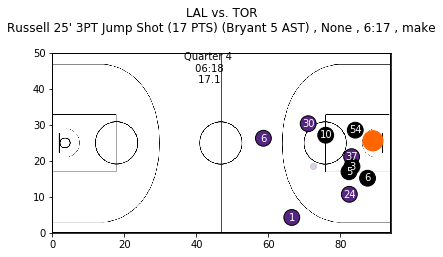

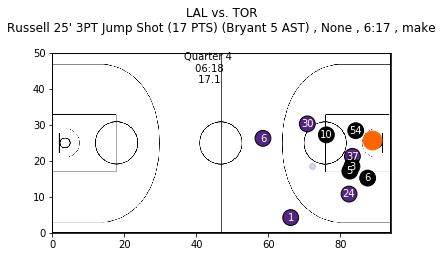

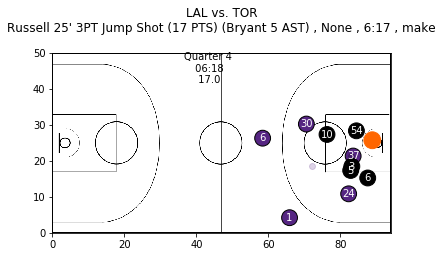

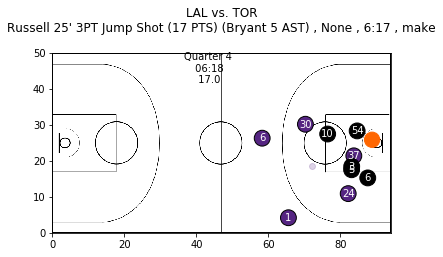

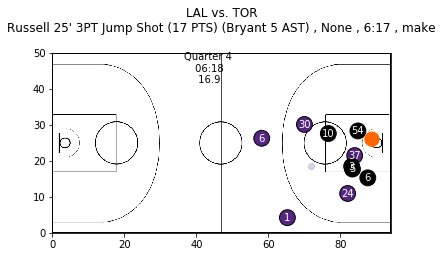

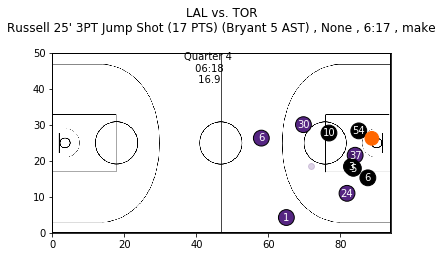

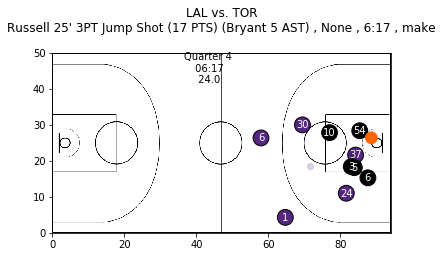

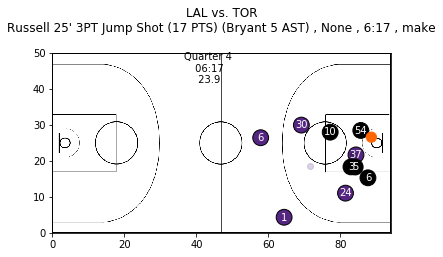

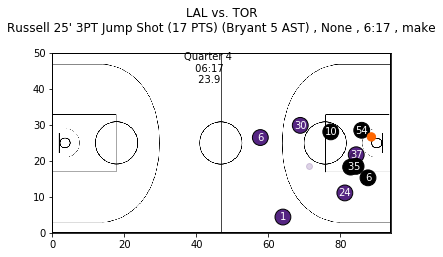

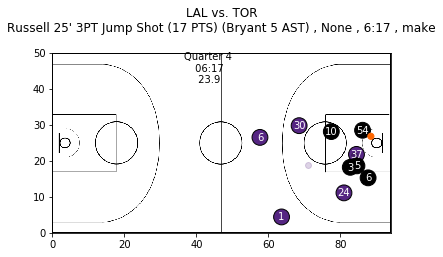

In [75]:
event = 188
moment_count = 402
difference = 5
for i in xrange((moment_count-difference),(moment_count+difference)):
    draw_court(event, i)

In [291]:

print home_team, away_team
prev = pd.DataFrame(moment_list[0][5])

compiled = [ball, home, away]
for moment in moment_list:
    curr = np.array(moment[5])
    if curr != prev:
        print 'changed'
        break
    prev = curr

        attack  time
0   1610612761    24
1   1610612747   229
2   1610612747   377
3   1610612761   478
4   1610612761   651
5   1610612747   670
6   1610612761   682
7   1610612747   703
8   1610612761   763
9   1610612761   792
10  1610612761   828
11  1610612747  1029
12  1610612747  1242
13  1610612747  1318
14  1610612761  1382
15  1610612761  1425
16  1610612761  1582
17  1610612747  1612
18  1610612761  1685
19  1610612761  1763
20  1610612747  1790
21  1610612761  1810
22  1610612747  1878
23  1610612761  1968
24  1610612761  2001
25  1610612747  2068
26  1610612747  2110
27  1610612747  2131
28  1610612747  2201
29  1610612761  2222
30  1610612747  2251
31  1610612761  2269
32  1610612761  2332
33  1610612761  2436
34  1610612747  2542
35  1610612747  2566
36  1610612761  2581
37  1610612747  2600
38  1610612747  2634
39  1610612747  2658
40  1610612761  2792


In [147]:
2805.37 / 60

46.756166666666665